# Stage 2

In this section, we want to be able to come up with a predictive model to be able to soundly predict the price of AirBnB listings based on features we deem are important.

In [256]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [257]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import folium

import warnings
warnings.filterwarnings("ignore")

In [258]:
df_initial = pd.read_csv('../data/listings.csv')

In [259]:
# checking shape
print("The dataset has {} rows and {} columns.".format(*df_initial.shape))

# ... and duplicates
print("It contains {} duplicates.".format(df_initial.duplicated().sum()))

The dataset has 39670 rows and 106 columns.
It contains 0 duplicates.


In [260]:
df_initial.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11156,https://www.airbnb.com/rooms/11156,20200316134854,2020-03-16,An Oasis in the City,Very central to the city which can be reached ...,Potts Pt. is a vibrant and popular inner-city...,Very central to the city which can be reached ...,none,"It is very close to everything and everywhere,...",...,f,f,moderate,f,f,1,0,1,0,1.55


In [261]:
# check the columns we currently have
df_initial.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)

## Preprocessing Data

### Deciding which columns to work with

Let's imagine we are in the shoes of someone who'd like to offer their home. Fixed features of our property include its rooms, size, and location. We also can decide on how we want to be listed: with a picture or not, how many minimum nights we want a guest to stay, whether we are instantly bookable, how we handle cancellations, etc. But we can neither be a "super host", nor do we have any reviews yet to show - although they can be very important for setting a price. So, let's focus only on features we can influence:

In [262]:
# define the columns we want to keep
columns_to_keep = ['id', 'space', 'description', 'host_has_profile_pic', 'neighbourhood_cleansed', 
                   'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'amenities', 'square_feet', 'price', 'cleaning_fee', 
                   'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',  
                   'instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

df_raw = df_initial[columns_to_keep].set_index('id')
print("The dataset has {} rows and {} columns - after dropping irrelevant columns.".format(*df_raw.shape))

The dataset has 39670 rows and 23 columns - after dropping irrelevant columns.


In [263]:
# Different room types
df_raw.room_type.value_counts(normalize=True)

Entire home/apt    0.627199
Private room       0.347013
Shared room        0.019082
Hotel room         0.006705
Name: room_type, dtype: float64

In [264]:
# Different property types
df_raw.property_type.value_counts(normalize=True)

Apartment                 0.596496
House                     0.256945
Townhouse                 0.042627
Condominium               0.019813
Guest suite               0.017998
Guesthouse                0.014520
Villa                     0.009024
Loft                      0.006226
Boutique hotel            0.005798
Serviced apartment        0.005420
Bungalow                  0.004865
Cottage                   0.004285
Bed and breakfast         0.003277
Hotel                     0.002521
Hostel                    0.002395
Other                     0.001613
Cabin                     0.001588
Tiny house                0.001311
Boat                      0.000731
Camper/RV                 0.000454
Aparthotel                0.000429
Tent                      0.000277
Farm stay                 0.000252
Earth house               0.000227
Barn                      0.000151
Island                    0.000101
Chalet                    0.000101
Dome house                0.000050
Train               

In [265]:
# Cleaning Price columns
df_raw[['price', 'cleaning_fee', 'extra_people', 'security_deposit']].head(3)

,price,cleaning_fee,extra_people,security_deposit
id,,,,
11156,$65.00,NaN,$0.00,NaN
12351,"$14,316.00",$55.00,$395.00,$0.00
14250,$471.00,$100.00,$40.00,$900.00


In [266]:
# Check for null values in price column
# checking Nan's in "price" column
df_raw.price.isna().sum()

0

In [267]:
# Check for nulls in cleaning_fee
df_raw.cleaning_fee.isna().sum()

10453

Plenty of null cleaning fees, so that might mean that the hosts do not charge extra for cleaning fees. So let's replace those with \$0.0 dollars.

In [268]:
df_raw.cleaning_fee.fillna('$0.00', inplace=True)
df_raw.cleaning_fee.isna().sum()

0

In [269]:
# Same for security deposit
df_raw.security_deposit.isna().sum()

13866

In [270]:
df_raw.security_deposit.fillna('$0.00', inplace=True)
df_raw.security_deposit.isna().sum()

0

In [271]:
# Let's remove the dollar signs in all four columns and convert the string values into numerical ones:

# clean up the columns (by method chaining)
df_raw.price = df_raw.price.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.cleaning_fee = df_raw.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.security_deposit = df_raw.security_deposit.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.extra_people = df_raw.extra_people.str.replace('$', '').str.replace(',', '').astype(float)

Investigate the `price` column. There might be cleaning need to be done here.

In [272]:
df_raw['price'].describe()

count    39670.000000
mean       218.327275
std        426.087963
min          0.000000
25%         80.000000
50%        130.000000
75%        218.000000
max      16156.000000
Name: price, dtype: float64

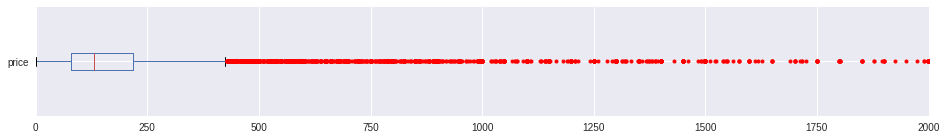

In [273]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df_raw['price'].plot(kind='box', xlim=(0, 2000), vert=False, flierprops=red_square, figsize=(16,2));

The pricing data is a bit messy as expected. 75% of the apartments charge close to 200 - but the maximum value is 16000. Let's decide on a limit of \$ 1000, after which the outliers seem to 'fringe', and drop all records that charge more than that. Oddly enough, we have prices set to 0, so let's drop those too.

In [274]:
df_raw.drop(df_raw[ (df_raw.price > 1000) | (df_raw.price == 0) ].index, axis=0, inplace=True)

In [275]:
print("The dataset has {} rows and {} columns - after being price-wise preprocessed.".format(*df_raw.shape))

The dataset has 38903 rows and 23 columns - after being price-wise preprocessed.


### Dealing with missing values

In [276]:
df_raw.isna().sum()

space                       11762
description                  1276
host_has_profile_pic            4
neighbourhood_cleansed          0
latitude                        0
longitude                       0
property_type                   0
room_type                       0
accommodates                    0
bathrooms                      17
bedrooms                       58
bed_type                        0
amenities                       0
square_feet                 38700
price                           0
cleaning_fee                    0
security_deposit                0
extra_people                    0
guests_included                 0
minimum_nights                  0
instant_bookable                0
is_business_travel_ready        0
cancellation_policy             0
dtype: int64

In [277]:
# drop columns with too many Nan's
df_raw.drop(columns=['square_feet', 'space'], inplace=True)

In [278]:
# drop rows with NaN's in bathrooms and bedrooms
df_raw.dropna(subset=['bathrooms', 'bedrooms', ], inplace=True)

In [279]:
df_raw.host_has_profile_pic.unique()


array(['t', 'f', nan], dtype=object)

In [280]:
# replace host_has_profile_pic Nan's with no
df_raw.host_has_profile_pic.fillna(value='f', inplace=True)
df_raw.host_has_profile_pic.unique()

array(['t', 'f'], dtype=object)

In [281]:
df_raw.isna().sum()


description                 1244
host_has_profile_pic           0
neighbourhood_cleansed         0
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                      0
bedrooms                       0
bed_type                       0
amenities                      0
price                          0
cleaning_fee                   0
security_deposit               0
extra_people                   0
guests_included                0
minimum_nights                 0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
dtype: int64

In [282]:
print("The dataset has {} rows and {} columns - after having dealt with missing values.".format(*df_raw.shape))

The dataset has 38832 rows and 21 columns - after having dealt with missing values.


## Feature Engineering

### Proximity to transport services

In [283]:
df_prox = pd.read_csv('../data/listings-proximity.csv')

df_prox.head(10)

,id,latitude,longitude,proximity
0,11156,-33.86917,151.22656,714.152785
1,12351,-33.86515,151.19190,99.764789
2,14250,-33.80093,151.26172,1614.550356
3,15253,-33.87964,151.21680,758.338171
4,44545,-33.87888,151.21439,531.088254
5,45440,-33.88909,151.27451,2321.480811
6,57183,-33.89185,151.27308,2283.149679
7,58506,-33.81927,151.23652,721.436486
8,59297,-33.90199,151.19305,726.367058
9,61721,-33.88890,151.27726,2439.433587


In [284]:
# merge full dataframe + add specific columns from df_2
df_raw = pd.merge(df_raw, df_prox[['id', 'proximity']], 
              left_on='id', right_on='id')

# shorten the name of one column
df_raw.rename({'neighbourhood_cleansed':'neighbourhood'}, axis=1, inplace=True)

# check the dataframe
print("The dataset has {} rows and {} columns - after combining it.".format(*df_raw.shape))
print("It contains {} duplicates.".format(df_raw.duplicated().sum()))
df_raw.head(2)

The dataset has 38832 rows and 23 columns - after combining it.
It contains 0 duplicates.


,id,description,host_has_profile_pic,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,price,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,proximity
0,11156,Very central to the city which can be reached ...,t,Sydney,-33.86917,151.22656,Apartment,Private room,1,1.0,...,65.0,0.0,0.0,0.0,1,2,f,f,moderate,714.152785
1,14250,"Beautifully renovated, spacious and quiet, our...",t,Manly,-33.80093,151.26172,House,Entire home/apt,6,3.0,...,471.0,100.0,900.0,40.0,6,5,f,f,strict_14_with_grace_period,1614.550356


### Lodging Amenities

I'm interested in what amenities hosts offer their guests, and in order to enrich our prediction, whether we can determine what some of the more special and/or rare amenities might be that make a property more desirable.

In [285]:
from collections import Counter

In [286]:
results = Counter()
df_raw['amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results.update)

results.most_common(30)

0        None
1        None
2        None
3        None
4        None
         ... 
38827    None
38828    None
38829    None
38830    None
38831    None
Name: amenities, Length: 38832, dtype: object

[('Kitchen', 36724),
 ('Essentials', 36103),
 ('Wifi', 35841),
 ('Washer', 35224),
 ('Smoke detector', 34438),
 ('TV', 32333),
 ('Hangers', 31510),
 ('Iron', 28975),
 ('Shampoo', 26736),
 ('Hair dryer', 26174),
 ('Laptop friendly workspace', 24822),
 ('Dryer', 24705),
 ('Heating', 23777),
 ('Hot water', 21726),
 ('Air conditioning', 18548),
 ('Refrigerator', 17344),
 ('Dishes and silverware', 17229),
 ('Free parking on premises', 16661),
 ('Microwave', 15782),
 ('Stove', 15106),
 ('Cooking basics', 15087),
 ('Oven', 14554),
 ('Bed linens', 14087),
 ('First aid kit', 12020),
 ('Fire extinguisher', 11732),
 ('Free street parking', 11271),
 ('Private entrance', 11242),
 ('Patio or balcony', 11124),
 ('Elevator', 10789),
 ('Dishwasher', 10667)]

In [287]:
sub_df = pd.DataFrame(results.most_common(30), columns=['amenity', 'count'])

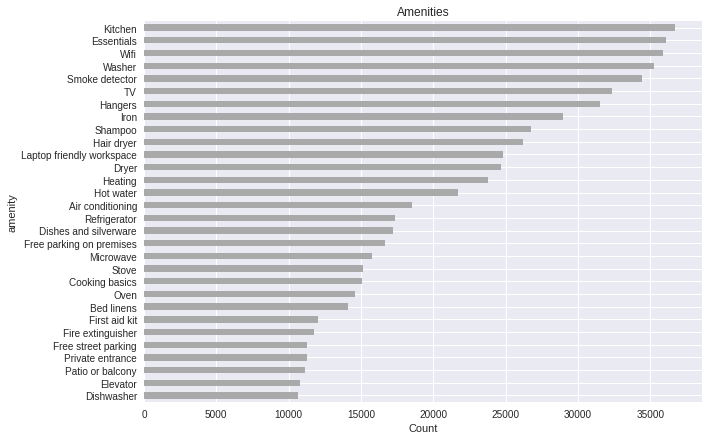

In [288]:
# plot the Top 20
sub_df.sort_values(by=['count'], ascending=True).plot(kind='barh', x='amenity', y='count',  
                                                      figsize=(10,7), legend=False, color='darkgrey',
                                                      title='Amenities')
plt.xlabel('Count');

In [289]:
df = df_raw

Let's add columns with amenities that are somewhat unique and not offered by all hosts:

- a laptop-friendly workspace
- a TV
- patio or balcony
- air conditioning and
- free parking

After doing this, let's drop the original column:

In [290]:
df['Laptop_friendly_workspace'] = df['amenities'].str.contains('Laptop friendly workspace')
df['TV'] = df['amenities'].str.contains('TV')
df['Balcony'] = df['amenities'].str.contains('Patio or balcony')
df['Air_Conditioning'] = df['amenities'].str.contains('Air conditioning')
df['Free_Parking'] = df['amenities'].str.contains('Free parking on premises') | df['amenities'].str.contains('Free street parking')

In [291]:
df.drop(['amenities'], axis=1, inplace=True)

## Make sure engineered features make sense

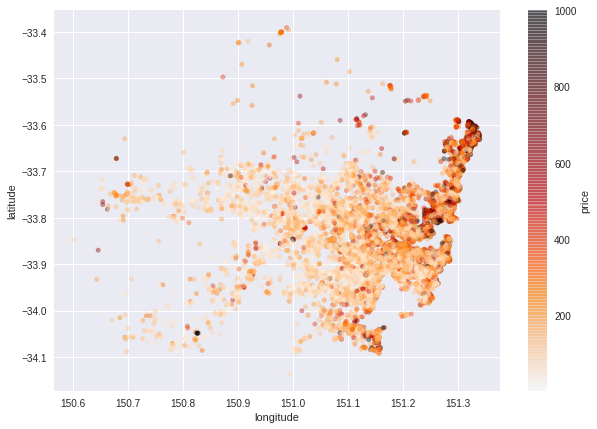

In [292]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), 
        c="price", cmap="gist_heat_r", colorbar=True, sharex=False);

__> Price Differences by Neighbourhood__

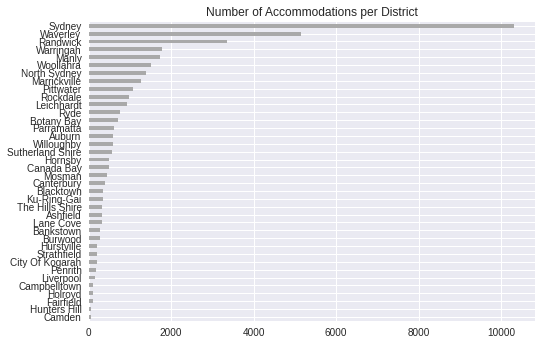

In [293]:
df['neighbourhood'].value_counts().sort_values().plot(kind='barh', color='darkgrey')
plt.title('Number of Accommodations per District');

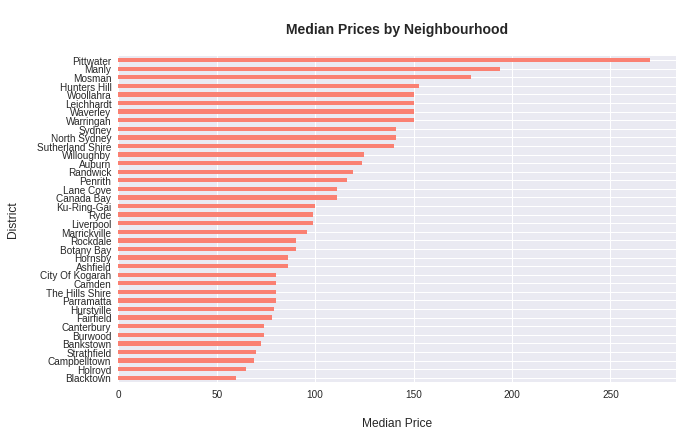

In [294]:
# group_by neighbourhood groups, take the median price and store new values in sub_df 
df_grouped = pd.DataFrame(df.groupby(['neighbourhood'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)

# plot this 
df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='neighbourhood', y='price', 
                figsize=(10,6), legend=False, color='salmon')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nMedian Prices by Neighbourhood\n', fontsize=14, fontweight='bold');

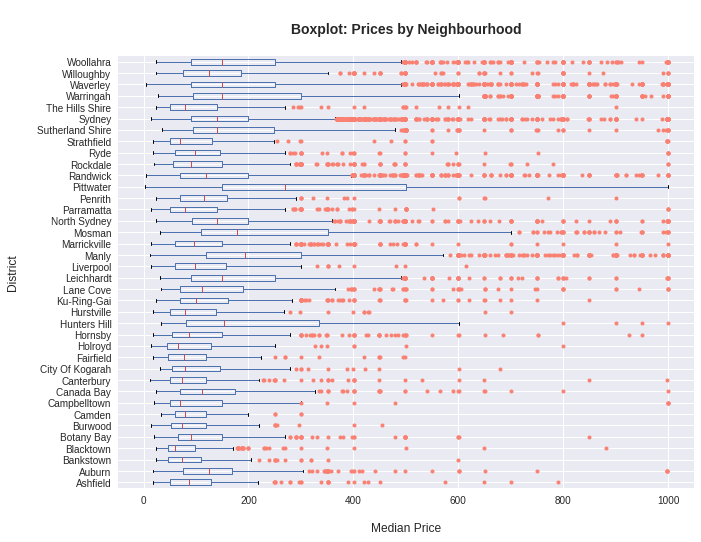

In [295]:
red_square = dict(markerfacecolor='salmon', markeredgecolor='salmon', marker='.')

df.boxplot(column='price', by='neighbourhood', 
           flierprops=red_square, vert=False, figsize=(10,8))

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nBoxplot: Prices by Neighbourhood\n', fontsize=14, fontweight='bold')

# get rid of automatic boxplot title
plt.suptitle('');

__> Price Differences by Accommodation Distance to Transport Services__

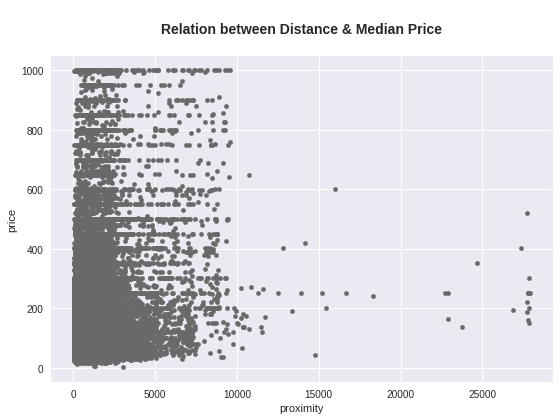

In [296]:
df.plot.scatter(x="proximity", y="price", figsize=(9,6), c='dimgrey')
plt.title('\nRelation between Distance & Median Price\n', fontsize=14, fontweight='bold');

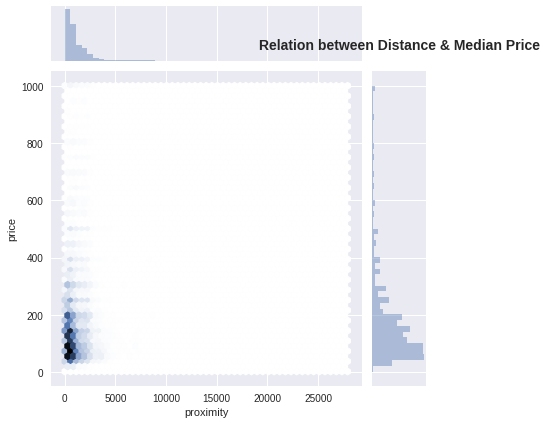

In [297]:
sns.jointplot(x=df["proximity"], y=df["price"], kind='hex')
plt.title('\nRelation between Distance & Median Price\n', fontsize=14, fontweight='bold');

__> Price Differences by Distance From Coastline__

It appears from the price, latitude, longitude heatmap that locations closer to the coast appear to have higher prices. Let's put that to the test.

In [298]:
import os

path = '../data/coastline/'
D = np.load(os.path.join(path,'coastal_basemap_data.npy'), allow_pickle=True).tolist()
lons,lats = D['lons'],D['lats']

def distance_from_coast(lons, lats, lon,lat):
    dists = np.sqrt((lons-lon)**2+(lats-lat)**2)

    return np.min(dists)

In [299]:
# df['Coastline_Dist'] = df.apply(lambda x : distance_from_coast(
#     lons, lats, x['longitude'], x['latitude']), axis=1)
# merge full dataframe + add specific columns from df_2
df_coast = pd.read_csv('../data/coastline_dat.csv')
df = pd.merge(df, df_coast[['id', 'Coastline_Dist']], 
              left_on='id', right_on='id')


In [300]:
df['Coastline_Dist'].describe()

count    38832.000000
mean         0.028640
std          0.048089
min          0.000101
25%          0.008136
50%          0.014236
75%          0.026442
max          0.475632
Name: Coastline_Dist, dtype: float64

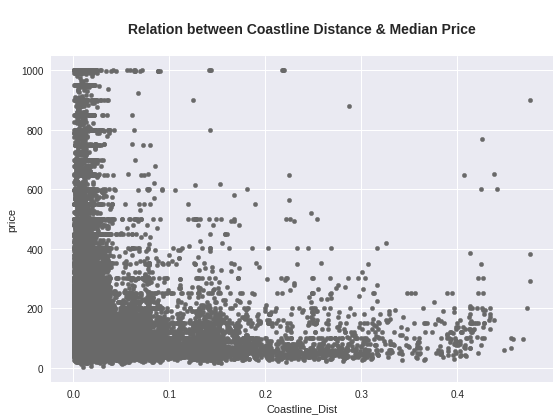

In [301]:
df.plot.scatter(x="Coastline_Dist", y="price", figsize=(9,6), c='dimgrey')
plt.title('\nRelation between Coastline Distance & Median Price\n', fontsize=14, fontweight='bold');

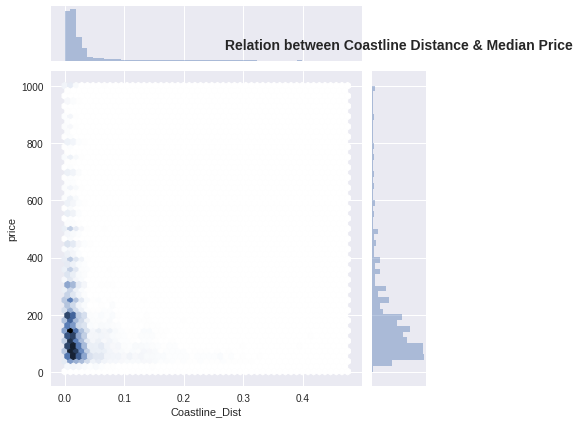

In [302]:
sns.jointplot(x=df["Coastline_Dist"], y=df["price"], kind='hex')
plt.title('\nRelation between Coastline Distance & Median Price\n', fontsize=14, fontweight='bold');

In [303]:
# # save the df for not having to rerun alg for calculating coastline distances
# header = ["id", "Coastline_Dist"]
# df.to_csv('../data/coastline_dat.csv', columns = header)

## Modeling the Data

### Preparing Target and Features

In [ ]:
df.columns

In [ ]:
df.info()

Let's drop some columns we don't need. E.g. `property_type`, `latitude` and `longitude` are no longer helpful. Let's also drop neighbourhood since we're working with the distance from the coastline as a measure of where the listing is.

In [ ]:
df.drop(['latitude', 'longitude', 'property_type', 'neighbourhood', 'is_business_travel_ready'], axis=1, inplace=True)

Now let's convert all string columns into categorical ones:

In [ ]:
for col in ['host_has_profile_pic', 'room_type', 'bed_type', 'instant_bookable', 'cancellation_policy']:
    df[col] = df[col].astype('category')

In [ ]:
# define our target
target = df[["price"]]

# define our features 
features = df.drop(["price", "id"], axis=1)

### Recoding Categorical Features

In [ ]:
num_feats = features.select_dtypes(include=['float64', 'int64', 'bool']).copy()

# one-hot encoding of categorical features
cat_feats = features.select_dtypes(include=['category']).copy()
cat_feats = pd.get_dummies(cat_feats)

In [ ]:
features_recoded = pd.concat([num_feats, cat_feats], axis=1)


In [ ]:
print(features_recoded.shape)
features_recoded.head(2)

In [306]:
len(features_recoded.columns)

34

# Hypothesis Testing

- Null Hypothesis ($H_0$) - AirBnB listing prices are not affected by the measure of their distance from the New South Wales shoreline.
- Alternate Hypothesis ($H_1$) - AirBnB listing prices **are** affected by the measure of their distance from the New South Wales shoreline

In [ ]:
import statsmodels.api as sm
import statsmodels

Xvar = features_recoded.copy()
Yvar = target

In [ ]:
Xvar = statsmodels.tools.tools.add_constant(Xvar, has_constant='raise')

In [ ]:
linearModel1=sm.OLS(Yvar, Xvar.astype(float), hasconst=True).fit()

In [254]:
linearModel1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     1570.
Date:                Sat, 23 May 2020   Prob (F-statistic):               0.00
Time:                        00:48:50   Log-Likelihood:            -2.3730e+05
No. Observations:               38832   AIC:                         4.747e+05
Df Residuals:                   38802   BIC:                         4.749e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
const                                              -0.7366      8.176     -0.090      0.928     -16.763      15.289
accommodates                                       18.0880      0.511     35.367      0.000      17.086      19.090
bathrooms                                          23.5122      1.017     23.125      0.000      21.519      25.505
bedrooms                                           38.0882      0.944     40.351      0.000      36.238      39.938
cleaning_fee                                        0.2746      0.010     28.011      0.000       0.255       0.294
security_deposit                                    0.0321      0.001     26.226      0.000       0.030       0.034
extra_people                                        0.0703      0.026      2.718      0.007       0.020       0.121
guests_included                                    -8.6416      0.523    -16.509      0.000      -9.668      -7.616
minimum_nights                                     -0.0760      0.028     -2.693      0.007      -0.131      -0.021
proximity                                           0.0100      0.000     22.827      0.000       0.009       0.011
Laptop_friendly_workspace                          -5.1397      1.207     -4.258      0.000      -7.506      -2.774
TV                                                 11.6504      1.570      7.421      0.000       8.573      14.728
Balcony                                           -11.4910      1.343     -8.554      0.000     -14.124      -8.858
Air_Conditioning                                    9.7721      1.200      8.142      0.000       7.420      12.125
Free_Parking                                       -7.0187      1.213     -5.784      0.000      -9.397      -4.640
Coastline_Dist                                   -429.2069     12.301    -34.893      0.000    -453.316    -405.097
host_has_profile_pic_f                             10.6991      7.346      1.456      0.145      -3.699      25.097
host_has_profile_pic_t                            -11.4357      5.777     -1.980      0.048     -22.758      -0.113
room_type_Entire home/apt                          11.4395      2.877      3.977      0.000       5.801      17.078
room_type_Hotel room                               77.7947      5.766     13.492      0.000      66.493      89.096
room_type_Private room                            -29.8058      2.818    -10.577      0.000     -35.329     -24.282
room_type_Shared room                             -60.1650      3.984    -15.102      0.000     -67.973     -52.357
bed_type_Airbed                                     7.2660     23.361      0.311      0.756     -38.521      53.053
bed_type_Couch                                    -18.2116     25.5

From our results, it shows that the P-value for a two-tailed T-Test on our `Coastline_Dist` feature shows that it is close to $0.000$. This means, that with a 95% confidence interval, we can say that the null hypothesis can be rejected. 

An interpretation of $H_0$ and $H_1$ from the values above can be inferred as follows. The $H_0$ states that the coefficient for the `Coastline_Dist` feature is $0$, i.e. the prices regressed using `Coastline_Dist` will be unaffected by any change in `Coastline_Dist`. However, $H_1$ states that the coefficient is $-429.2069$, which means - that for every 1 unit increase in distance from the coast line, the price drops by 429 dollars. The t-statistic caluclated using the Standard Error measures to $-34.893$, which gives us a P-value close to $0.000$. Using this p-value, we can reject the null hypothesis. 

# Feature Selection using Backward Elimination

We create a multivariable linear regressor by eliminating features iteratively, and building a model with a reduced set of features in each iteration. This is performed until all the reamining features have a p-value of less than $0.05$, i.e. we can accept all features to have a coefficient higher than 0 with a 95% confidence interval.

In [ ]:


drop_cols1 = ['host_has_profile_pic_f', 'bed_type_Airbed', 'bed_type_Couch', 'bed_type_Futon', 'bed_type_Pull-out Sofa', 
             'bed_type_Real Bed', 'instant_bookable_f', 'instant_bookable_t',
             'cancellation_policy_flexible', 'cancellation_policy_moderate', 'cancellation_policy_strict',
             'cancellation_policy_strict_14_with_grace_period']
Xvar1 = Xvar.drop(drop_cols1, axis=1)

In [ ]:
Xvar1.columns

In [ ]:
linearModel2=sm.OLS(Yvar, Xvar1.astype(float), hasconst=True).fit()

In [304]:
linearModel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     2149.
Date:                Sun, 24 May 2020   Prob (F-statistic):               0.00
Time:                        02:01:30   Log-Likelihood:            -2.3739e+05
No. Observations:               38832   AIC:                         4.748e+05
Df Residuals:                   38810   BIC:                         4.750e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  32.0668      8.566      3.744      0.000      15.277      48.856
accommodates                           17.9042      0.511     35.012      0.000      16.902      18.907
bathrooms                              23.6949      1.019     23.254      0.000      21.698      25.692
bedrooms                               39.0544      0.941     41.517      0.000      37.211      40.898
cleaning_fee                            0.2643      0.010     27.435      0.000       0.245       0.283
security_deposit                        0.0326      0.001     26.772      0.000       0.030       0.035
extra_people                            0.0624      0.026      2.415      0.016       0.012       0.113
guests_included                        -9.0189      0.523    -17.235      0.000     -10.045      -7.993
minimum_nights                         -0.0655      0.028     -2.319      0.020      -0.121      -0.010
proximity                               0.0103      0.000     23.414      0.000       0.009       0.011
Laptop_friendly_workspace              -6.1750      1.207     -5.117      0.000      -8.540      -3.810
TV                                     12.0100      1.572      7.640      0.000       8.929      15.091
Balcony                               -13.6582      1.333    -10.247      0.000     -16.271     -11.046
Air_Conditioning                        9.4492      1.201      7.870      0.000       7.096      11.802
Free_Parking                           -7.6212      1.215     -6.271      0.000     -10.003      -5.239
Coastline_Dist                       -431.1865     12.317    -35.006      0.000    -455.329    -407.044
host_has_profile_pic_t                -22.9383     10.405     -2.204      0.027     -43.333      -2.544
room_type_Entire home/apt              19.7964      2.802      7.066      0.000      14.305      25.288
room_type_Hotel room                   84.5479      5.950     14.211      0.000      72.887      96.209
room_type_Private room                -20.8553      2.730     -7.639      0.000     -26.206     -15.504
room_type_Shared room                 -51.4222      4.035    -12.744      0.000     -59.331     -43.513
cancellation_policy_super_strict_30    18.8716     11.484      1.643      0.100      -3.637      41.380
cancellation_policy_super_strict_60    38.3418      9.315      4.116      0.000      20.085      56.599
==============================================================================
Omnibus:                    20429.550   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           327749.484
Skew:                           2.165   Prob(JB):                         0.00
Kurtosis:                      16.558   Cond. No.              

In [ ]:
drop_cols2 = ['room_type_Private room', 'room_type_Shared room', 'cancellation_policy_super_strict_30']
Xvar2 = Xvar1.drop(drop_cols2, axis=1)

In [ ]:
linearModel3=sm.OLS(Yvar, Xvar2.astype(float), hasconst=True).fit()

In [305]:
linearModel3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     2368.
Date:                Sun, 24 May 2020   Prob (F-statistic):               0.00
Time:                        02:01:52   Log-Likelihood:            -2.3742e+05
No. Observations:               38832   AIC:                         4.749e+05
Df Residuals:                   38812   BIC:                         4.751e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   8.8292     10.529      0.839      0.402     -11.808      29.467
accommodates                           17.8511      0.512     34.892      0.000      16.848      18.854
bathrooms                              23.3306      1.019     22.905      0.000      21.334      25.327
bedrooms                               39.1242      0.941     41.572      0.000      37.280      40.969
cleaning_fee                            0.2671      0.010     27.914      0.000       0.248       0.286
security_deposit                        0.0326      0.001     26.726      0.000       0.030       0.035
extra_people                            0.0577      0.026      2.232      0.026       0.007       0.108
guests_included                        -8.9679      0.524    -17.126      0.000      -9.994      -7.942
minimum_nights                         -0.0678      0.028     -2.396      0.017      -0.123      -0.012
proximity                               0.0103      0.000     23.509      0.000       0.009       0.011
Laptop_friendly_workspace              -6.0960      1.205     -5.057      0.000      -8.458      -3.733
TV                                     12.3077      1.573      7.826      0.000       9.225      15.390
Balcony                               -13.5250      1.333    -10.145      0.000     -16.138     -10.912
Air_Conditioning                        9.5335      1.201      7.938      0.000       7.180      11.887
Free_Parking                           -7.2071      1.215     -5.934      0.000      -9.588      -4.826
Coastline_Dist                       -429.5677     12.324    -34.855      0.000    -453.724    -405.412
host_has_profile_pic_t                -22.3724     10.412     -2.149      0.032     -42.781      -1.964
room_type_Entire home/apt              42.1039      1.457     28.896      0.000      39.248      44.960
room_type_Hotel room                  107.3260      6.913     15.525      0.000      93.776     120.876
cancellation_policy_super_strict_60    37.8469      9.319      4.061      0.000      19.582      56.112
==============================================================================
Omnibus:                    20388.782   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           325878.474
Skew:                           2.160   Prob(JB):                         0.00
Kurtosis:                      16.518   Cond. No.                     4.65e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.65e+04. This might indicate that there are
strong multicollinearity or other 

The R-squared value for the linear models drop after performing feature selection, so we're better off without dropping them.

# Try out different models

Methodology - Use grid search cv to find the best parameters using cross validation of kfolds = 10 for each linear model and also xgboost.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_recoded, target, test_size=0.2, random_state=42)

In [ ]:
# # Split and scale the data
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test  = sc.transform(X_test)

## Linear Regressor

In [ ]:
from sklearn.linear_model import LinearRegression

In [312]:
# Grid search parameters
model = LinearRegression()
param_grid = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True]}
gl = GridSearchCV(model,param_grid, cv=10, scoring='r2')
gl.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'copy_X': [True], 'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [313]:
print('Grid search mean and stdev:\n')
for params, mean_score, std_dev in zip(gl.cv_results_['params'], gl.cv_results_['mean_test_score'], gl.cv_results_['std_test_score']):
    print("{:0.3f} (+/-{:0.03f}) for {}".format(
            mean_score, std_dev * 2, params))
print('\nLinear Regressor best params:\n', gl.best_params_)
print('\nLinear Regressor r-squared on training data:\n', gl.score(X_train, y_train))
print('\nLinear Regressor r-squared on test data:\n', gl.score(X_test, y_test))

Grid search mean and stdev:

-15737166176773607424.000 (+/-94422997060641636352.000) for {'copy_X': True, 'fit_intercept': True, 'normalize': True}
0.536 (+/-0.040) for {'copy_X': True, 'fit_intercept': True, 'normalize': False}
0.536 (+/-0.040) for {'copy_X': True, 'fit_intercept': False, 'normalize': True}
0.536 (+/-0.040) for {'copy_X': True, 'fit_intercept': False, 'normalize': False}

Linear Regressor best params:
 {'copy_X': True, 'fit_intercept': False, 'normalize': True}

Linear Regressor r-squared on training data:
 0.5399022219614744

Linear Regressor r-squared on test data:
 0.5388431919502075


In [307]:
pd.DataFrame(gl.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_copy_X,param_fit_intercept,param_normalize,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.162939,0.011603,0.017744,0.003198,True,True,True,"{'copy_X': True, 'fit_intercept': True, 'norma...",0.527606,0.531845,...,-1.573717e+20,0.524032,0.551496,0.541805,0.550933,0.559752,0.556876,-1.573717e+19,4.721150e+19,4
1,0.162199,0.017600,0.017384,0.002097,True,True,False,"{'copy_X': True, 'fit_intercept': True, 'norma...",0.527598,0.532470,...,4.909134e-01,0.524243,0.551505,0.541664,0.551219,0.559864,0.556862,5.357521e-01,1.995465e-02,3
2,0.151888,0.010759,0.016980,0.001864,True,False,True,"{'copy_X': True, 'fit_intercept': False, 'norm...",0.527598,0.532470,...,4.909396e-01,0.524243,0.551505,0.541664,0.551219,0.559864,0.556862,5.357547e-01,1.994877e-02,1
3,0.164746,0.040656,0.018091,0.003357,True,False,False,"{'copy_X': True, 'fit_intercept': False, 'norm...",0.527598,0.532470,...,4.909396e-01,0.524243,0.551505,0.541664,0.551219,0.559864,0.556862,5.357547e-01,1.994877e-02,1


## XGBoost Regressor

In [ ]:
import xgboost as xgb

Some of the important hyperparameters to tune an XGBoost are:

- `n_estimators`    = Number of trees one wants to build.
- `learning_rate`   = Rate at which our model learns patterns in data. After every round, it shrinks the feature weights to reach the best optimum.
- `max_depth`   = Determines how deeply each tree is allowed to grow during any boosting round.
- `colsample_bytree` = Percentage of features used per tree.
- `gamma`   = Specifies the minimum loss reduction required to make a split.

In [315]:
booster = xgb.XGBRegressor()
# create Grid
param_grid = {'n_estimators': [200, 250],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [7, 8, 9],
              'colsample_bytree': [0.5, 0.6, 0.7],
              'gamma': [0.0, 0.1, 0.2]}
# instantiate the tuned random forest
gbs = GridSearchCV(booster, param_grid, cv=10, n_jobs=-1, scoring='r2')
# train the tuned random forest
fit_params={"early_stopping_rounds":10, 
            "eval_metric" : "rmse", 
            "eval_set" : [[X_test, y_test]]}

gbs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estim...
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=-1,
             param_grid={

In [200]:
# gbs = load_model('_colsample_bytree_0.6___gamma_0.2___learning_rate_0.05___max_depth_9___n_estimators_200__gbs', "../models/")

In [316]:
print('Grid search mean and stdev:\n')
for params, mean_score, std_dev in zip(gbs.cv_results_['params'], gbs.cv_results_['mean_test_score'], gbs.cv_results_['std_test_score']):
    print("{:0.3f} (+/-{:0.03f}) for {}".format(
            mean_score, std_dev * 2, params))
print('\XGB Regressor best params:\n', gbs.best_params_)
print('\XGB Regressor r-squared on training data:\n', gbs.score(X_train, y_train))
print('\XGB Regressor r-squared on test data:\n', gbs.score(X_test, y_test))

Grid search mean and stdev:

0.598 (+/-0.026) for {'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200}
0.628 (+/-0.024) for {'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 250}
0.603 (+/-0.026) for {'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 200}
0.632 (+/-0.024) for {'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 250}
0.606 (+/-0.026) for {'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200}
0.635 (+/-0.025) for {'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 250}
0.659 (+/-0.024) for {'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}
0.660 (+/-0.024) for {'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 250}
0.6

\XGB Regressor r-squared on training data:
 0.8429225555573611
\XGB Regressor r-squared on test data:
 0.6505580834182669


In [ ]:
from sklearn.externals import joblib

def save_model(name, filepath, model):
    if not os.path.exists(os.path.dirname(filepath)):
        try:
            os.makedirs(os.path.dirname(filepath))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    param_name = "_".join([f"_{k}_{v}_" for k,v in model.best_params_.items()])
    joblib.dump(model, os.path.join(filepath, f"{param_name}_{name}"))

def load_model(name, filepath):
    model = joblib.load(os.path.join(filepath, name))
    return model

In [318]:
save_model("gbs_fit_params", "../models/", gbs)

In [319]:
pd.DataFrame(gbs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,16.180810,4.285862,0.116398,0.038184,0.5,0,0.01,7,200,"{'colsample_bytree': 0.5, 'gamma': 0.0, 'learn...",...,0.607748,0.584523,0.610423,0.576560,0.595085,0.616624,0.613187,0.598366,0.012833,162
1,25.786253,3.205927,0.162836,0.091383,0.5,0,0.01,7,250,"{'colsample_bytree': 0.5, 'gamma': 0.0, 'learn...",...,0.633307,0.614752,0.640356,0.606629,0.624255,0.643331,0.643573,0.627784,0.012098,135
2,20.953347,2.213990,0.111232,0.004225,0.5,0,0.01,8,200,"{'colsample_bytree': 0.5, 'gamma': 0.0, 'learn...",...,0.610862,0.588432,0.615096,0.580268,0.600594,0.620701,0.617810,0.603276,0.012801,151
3,27.603815,3.482147,0.184345,0.060319,0.5,0,0.01,8,250,"{'colsample_bytree': 0.5, 'gamma': 0.0, 'learn...",...,0.635791,0.618331,0.644767,0.609743,0.629925,0.647449,0.648125,0.632486,0.012249,124
4,23.355709,2.717865,0.184733,0.072455,0.5,0,0.01,9,200,"{'colsample_bytree': 0.5, 'gamma': 0.0, 'learn...",...,0.611039,0.590026,0.617848,0.581953,0.605805,0.622839,0.621190,0.606058,0.012766,142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,22.420135,0.817434,0.114237,0.004287,0.7,0.2,0.1,7,250,"{'colsample_bytree': 0.7, 'gamma': 0.2, 'learn...",...,0.651067,0.637129,0.668883,0.633379,0.659743,0.651814,0.670201,0.655220,0.011855,82
158,20.955776,0.626432,0.106915,0.001811,0.7,0.2,0.1,8,200,"{'colsample_bytree': 0.7, 'gamma': 0.2, 'learn...",...,0.641571,0.641132,0.666108,0.633432,0.659982,0.653909,0.675074,0.655411,0.012496,80
159,25.617624,0.857935,0.136676,0.016234,0.7,0.2,0.1,8,250,"{'colsample_bytree': 0.7, 'gamma': 0.2, 'learn...",...,0.640340,0.636739,0.667118,0.634405,0.660564,0.652124,0.675486,0.654802,0.013178,94
160,23.463046,0.608991,0.124061,0.003819,0.7,0.2,0.1,9,200,"{'colsample_bytree': 0.7, 'gamma': 0.2, 'learn...",...,0.643598,0.643375,0.668119,0.634059,0.658127,0.652380,0.674910,0.655199,0.011590,83


# Evaluating Models

In [224]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import math
import numpy as np

def pipeline(alg, features, target, alg_params=None, drop=False, dropped_cols=None):
    if drop and not dropped_cols:
        raise Exception("No columns specified after setting drop parameter to true.")

    if drop:
        features = features.drop(dropped_cols, axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    if not alg_params:
        clf = alg()
    else:
        clf = alg(**alg_params)

    
    _ = clf.fit(X_train, y_train)
    if alg != xgb.XGBRegressor:
        print('Intercept:', clf.intercept_)
        print('Coefficients:\n', clf.coef_)
    print('\nR-squared:', clf.score(X_train, y_train))
    
    # We can predict the median price for a new neighbourhoods
    print('\nPredicted price of first five data points from test split:\n', clf.predict(X_test)[:5])

#     if alg == xgb.XGBRegressor:
#         # We can also calculate the standard error
#         stderr = math.sqrt(np.mean((y_train - clf.predict(X_train.reshape(len(X_train), 1)))**2))
#         print('\nStandard error:', stderr)
#     else:
#         # We can also calculate the standard error
#         stderr = math.sqrt(np.mean((y_train - clf.predict(X_train)**2)))
#         print('\nStandard error:', stderr)
    
    return clf, X_train, X_test, y_train, y_test

def evaluate_model(clf, X_train, X_test, y_train, y_test, _type='xgb'):
    se2 = math.sqrt(mean_squared_error(y_train, clf.predict(X_train)))
    print('Standard error using sklearn.metrics:', se2)

    print('\nPredictions should be within {:.1f} dollars at 95% confidence according to training data.'.format(2*se2))
    se_test = math.sqrt(mean_squared_error(y_test, clf.predict(X_test)))
    print('Predictions should be within {:.1f} dollars at 95% confidence according to test data.'.format(2*se_test))
    
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    if _type == 'xgb':
        y_pred_train = y_pred_train.reshape(len(y_pred_train), 1)
        y_pred_test = y_pred_test.reshape(len(y_pred_test), 1)
    print('\nResidual plot for training data (blue) and test data (green):')
    _ = plt.scatter(y_pred_train, y_train-y_pred_train, c='blue', s=40, alpha=0.5, edgecolor='white')
    _ = plt.scatter(y_pred_test, y_test-y_pred_test, c='green', s=40, alpha=0.5, edgecolor='white')
    _ = plt.xlim([-100, 1000])
    _ = plt.ylim([-1000, 1000])
    _ = plt.plot([-100,1000], [0,0], c='black')
    _ = plt.ylabel('Residuals ($y - \hat{y}$)')
    _ = plt.xlabel('Predicted values ($\hat{y}$)')


## Linear Regressor

In [204]:
lm, X_train, X_test, y_train, y_test = pipeline(LinearRegression, features_recoded, target,  alg_params=gl.best_params_)

Intercept: 0.0
Coefficients:
 [[ 1.93454929e+01  2.35919992e+01  3.66434716e+01  2.70783396e-01
   3.13265268e-02  9.08455528e-02 -8.67525750e+00 -9.37999797e-02
   9.97050887e-03 -5.45078086e+00  1.16360831e+01 -1.23376080e+01
   9.21883745e+00 -7.56212282e+00 -4.23624627e+02  7.16884161e+00
  -8.94064476e+00  1.04528782e+01  7.92544378e+01 -2.85174324e+01
  -6.29616868e+01  6.79328680e+00 -2.04805765e+01  1.27155387e+01
  -5.02500404e+00  4.22495189e+00  3.48084813e+00 -5.25265128e+00
   2.86728166e+01  1.08631930e+01 -1.74091101e+02  2.09057434e+01
   4.77217951e+01  6.41557497e+01]]

R-squared: 0.5399022219614744

Predicted price of first five data points from test split:
 [[229.90937926]
 [152.76523583]
 [114.27682749]
 [140.60893636]
 [159.56287576]]


Standard error using sklearn.metrics: 109.6096845478297

Predictions should be within 219.2 dollars at 95% confidence according to training data.
Predictions should be within 213.9 dollars at 95% confidence according to test data.

Residual plot for training data (blue) and test data (green):


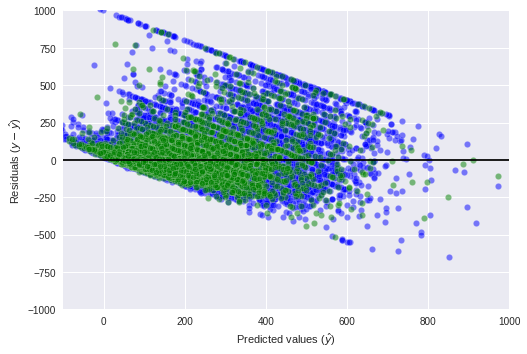

In [225]:
evaluate_model(lm, X_train, X_test, y_train, y_test, _type='lm')

## XGB Regressor

In [320]:
gb, X_train, X_test, y_train, y_test = pipeline(xgb.XGBRegressor, features_recoded, target,  alg_params=gbs.best_params_)


R-squared: 0.8429225555573611

Predicted price of first five data points from test split:
 [196.03705 178.24094 102.46276 143.4693  150.09505]


Standard error using sklearn.metrics: 64.04434279160965

Predictions should be within 128.1 dollars at 95% confidence according to training data.
Predictions should be within 186.2 dollars at 95% confidence according to test data.

Residual plot for training data (blue) and test data (green):


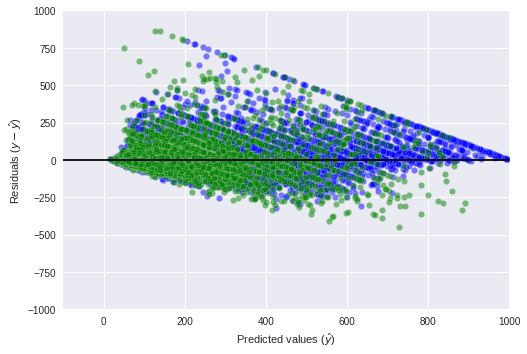

In [321]:
evaluate_model(gb, X_train, X_test, y_train, y_test, _type='xgb')

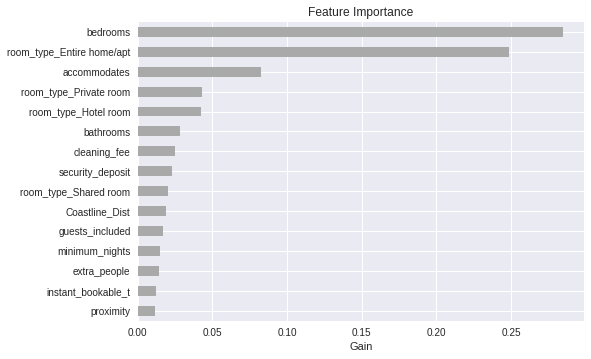

In [322]:
# plot the important features
feat_importances = pd.Series(gb.feature_importances_, index=features_recoded.columns)
_ = feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey')
_ = plt.xlabel('Gain');
_ = plt.title('Feature Importance')

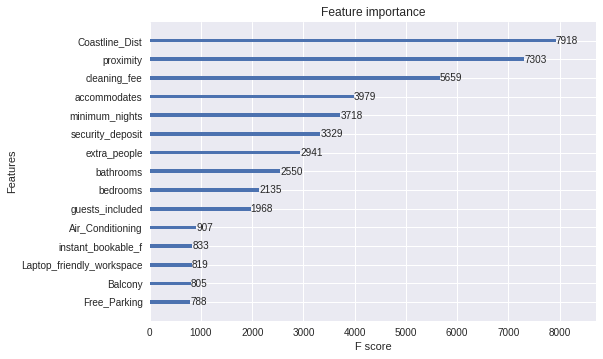

In [323]:
from xgboost import plot_importance

ax = plot_importance(gb, max_num_features=15)

## Is XGB Regressor better than Linear Regressor?

In [241]:
from sklearn.model_selection import cross_val_score

gb_cv = xgb.XGBRegressor(**gbs.best_params_)
XG_SCORE = cross_val_score(gb_cv, features_recoded, target, cv=100, scoring='r2', n_jobs=-1)


In [242]:
lm_cv = LinearRegression(**gl.best_params_)
LM_SCORE = cross_val_score(lm_cv, features_recoded, target, cv=100, scoring='r2', n_jobs=-1)

In [249]:
print(f"The mean score of XGB Regressor -> {np.mean(XG_SCORE):.2f} is greater than the mean score of Linear Regressor -> {np.mean(LM_SCORE):.2f}")

The mean score of XGB Regressor -> 0.64 is greater than the mean score of Linear Regressor -> 0.52


- Null Hypothesis $H_0$ - The Linear Regressor and XGB Regressor perform similarly and there is no significant difference in predection power between the two.
- Alternate Hypothesis $H_1$ - The XGB Regressor is a better predictor than the Linear Regressor

In [250]:
from scipy import stats
p_val = stats.ttest_ind(XG_SCORE, LM_SCORE).pvalue*0.5 # Calcuate p-value for one-tailed t-test

In [253]:
ALPHA = 0.05
if p_val < ALPHA:
    print(f"We reject H_0 as {p_val}, when the alternative says that XGBRegressor is the better predictor.")

We reject H_0 as 1.3247202608446335e-16, when the alternative says that XGBRegressor is the better predictor.


## Improving XGB

In [325]:
xg_train = xgb.DMatrix(data=X_train, label=y_train)

cv_results = xgb.cv(dtrain=xg_train, params=gbs.best_params_, nfold=10,
                    num_boost_round=200, early_stopping_rounds=10, 
                    metrics="rmse", as_pandas=True)

[11:02:41] WARNING: /workspace/src/learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:02:41] WARNING: /workspace/src/learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:02:41] WARNING: /workspace/src/learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you 

In [326]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,230.582401,0.555572,230.745622,5.131945
1,221.398184,0.590916,221.789787,5.047141
2,212.593506,0.554989,213.263051,4.978152
3,204.323575,0.594001,205.271103,4.871698
4,196.553459,0.615190,197.771918,4.755547


In [327]:
cv_results.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
180,63.441406,0.634396,94.304091,3.492039
181,63.388787,0.626969,94.302741,3.490188
182,63.320701,0.629836,94.300933,3.484378
183,63.284199,0.632571,94.298985,3.480457
184,63.217543,0.618197,94.298110,3.483103
